# NN_Polar_Decoder

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline
import gc
gc.collect(generation=2)

4

### Parameters

In [2]:
k = 11
N = 64
R = k/N
SNR_dB = 3     
noise_power = 1/10**(SNR_dB/10)
noise_power = noise_power * 2
print("noise_power:", noise_power)    # 1/2*No
print("noise_sigma:", np.sqrt(noise_power/2))

noise_power: 1.0023744672545447
noise_sigma: 0.7079457843841379


### Define Noise & Modulator

In [3]:
def BPSK_modulator(x):
    return -2*x +1

In [4]:
def qpsk_NRZ_encoder(x):
    half_CWs = int(x.shape[1]/2)    # half codewords length
    for i in range(x.shape[0]):     # batch_size
        for j in range(half_CWs):
            if (x[i,j] == x[i,j+half_CWs]):  # 00 & 11 -> -2*x +1
                x[i,j] = (-2*x[i,j]) +1
                x[i,j+half_CWs] = (-2*x[i,j+half_CWs]) +1      
            if (x[i,j] != x[i,j+half_CWs]):  # 01 & 10 -> 2*x -1
                x[i,j] = (2*x[i,j]) -1
                x[i,j+half_CWs] = (2*x[i,j+half_CWs]) -1     
    return x/np.sqrt(2)

In [5]:
def QPSK_modulator(x):
    # X = after polar encoding (256,16)
    # QPSK step : 
    # First : 把實部虛部分開，並把虛部丟在實部後面
    real = []
    imag = []
    stack = []
    for n in range(x.shape[0]):  # batch-size
        for m in range(0, x.shape[1], 2): 
            stack.append(x[n,m])  # real-part
        real.append(stack)
        stack = []
        for m in range(1, x.shape[1], 2): 
            stack.append(x[n,m])  # imag-part
        imag.append(stack)
        stack = []
    symbol_np = np.hstack((real, imag))
    # Second : NRZ-encoding (0 -> +1 ; 1 -> -1)
    # symbol_nrz = (-2*symbol_np +1)/np.sqrt(2)
    symbol_nrz = qpsk_NRZ_encoder(symbol_np)
    return symbol_nrz

In [6]:
def AWGN_addNoise(x, awgn_power):
    sym_num = int(x.shape[1]/2)
    y = np.zeros((x.shape[0],x.shape[1]))
    for i in range (x.shape[0]):       # batch-size
        for j in range (sym_num):      # no_of_bits
            y[i,j] = x[i,j] + np.sqrt(awgn_power/2) * np.random.normal(0,1)                   # real-part
            y[i,j+sym_num] = x[i,j+sym_num] + np.sqrt(awgn_power/2) * np.random.normal(0,1)   # imag-part
    return y

In [7]:
def FineTuning_addNoise(x, awgn_power):
    sym_num = int(x.shape[1]/2)
    y = np.zeros((x.shape[0],x.shape[1]))
    for i in range (x.shape[0]):       # batch-size
        real_add_impulse = np.random.randint(low=0, high=sym_num)
        for j in range (sym_num):      # no_of_bits
            if (j == real_add_impulse) :
                IGR = 100              # 高斯脈衝能量比
                impulse_power = awgn_power * IGR
                y[i,j] = x[i,j] + np.sqrt(impulse_power/2) * np.random.normal(0,1)                  # real-part
                y[i,j+sym_num] = x[i,j+sym_num] + np.sqrt(impulse_power/2) * np.random.normal(0,1)  # imag-part
            else : 
                y[i,j] = x[i,j] + np.sqrt(awgn_power/2) * np.random.normal(0,1)                     # real-part
                y[i,j+sym_num] = x[i,j+sym_num] + np.sqrt(awgn_power/2) * np.random.normal(0,1)     # imag-part
    return y

In [8]:
def Test_addNoise(x, awgn_power, impulse_prob):
    sym_num = int(x.shape[1]/2)
    y = np.zeros((x.shape[0],x.shape[1]))
    for i in range (x.shape[0]):       # batch-size
        for j in range (sym_num):      # no_of_bits
            dice = np.random.uniform(0,1)   # 0~1 隨機選一個小數
            if dice <= prob :
                IGR = 100              # 高斯脈衝能量比
                impulse_power = awgn_power * IGR
                y[i,j] = x[i,j] + np.sqrt(impulse_power/2) * np.random.normal(0,1)           # real-part
                y[i,j+sym_num] = x[i,j+sym_num] + np.sqrt(impulse_power/2) * np.random.normal(0,1)   # imag-part
            else : 
                y[i,j] = x[i,j] + np.sqrt(awgn_power/2) * np.random.normal(0,1)              # real-part
                y[i,j+sym_num] = x[i,j+sym_num] + np.sqrt(awgn_power/2) * np.random.normal(0,1)      # imag-part
    return y

### Polar Encoder (Bhattacharyya)

In [9]:
"""
    Algorithm : The Bhattacharyya bounds
"""
def polarization_channel_awgn(N, k, design_snr_dB=0):  
    design_snr_dB = design_snr_dB +10*np.log10(k/N)
    S = 10**(design_snr_dB/10)       # S : R*Eb/N0
    n = np.log2(N)                   # N = 2^n
    z0 = np.zeros(N)                 # N : Codewords length
    # initial the Bhattacharyya parameter of BI-AWGN channel,be replaced with exp(−R*Eb/N0)
    z0[0] = np.exp(-S)               # initial erasure-probability of channel        
    for j in range(1,int(n)+1):      # How many stage to polarization (output-to-input)
        u = 2**j                     # 2^n = N = 幾個 W 副本通道
        for t in range(0,int(u/2)):  # For each connection
            T = z0[t]
            z0[t] = 2*T - T**2       # upper channel (+ channel)
            z0[int(u/2)+t] = T**2    # lower channel (- channel)
    # sort into increasing order
    # z0 array 裝的是每個分離通道的 Prob.Error 數值，
    # 數值越大代表通道越糟
    #====> 通道由最好排到最差 (左[0]->右[N]) <====#
    idx = np.argsort(z0)             
    # argsort() 返回的是數組值從小到大的索引值
    #====> 通道由最好排到最差 (左[0]->右[N]) <====#
    # select k best channels
    # 選最好的前半部分通道做 bit-reversal
    ######### idx = np.sort(bitrevorder(idx[0:k]))
    A = np.zeros(N, dtype=bool)
    A[idx[0:k]] = True   # 將 Good_channel 設為可傳 info.
    # idx 為 " 好的通道 " bit-reversal 後的新通道
    return A

def polar_xor_encoding(u):  
    # 每一組 codewords 為 16-bits , 共 256 組
    N = len(u)   # 只看第一維 N = 2**k
    n = 1
    x = np.copy(u)
    stages = np.log2(N).astype(int)   # 通道共分裂成幾階
    for s in range(0,stages):         # s = stage
        i = 0                         # i = no.of samples
        while i < N:                  # N = 256            
            for j in range(0,n):      # j always = 0
                idx = i+j
                x[idx] = x[idx] ^ x[idx+n]  # XOR : Good Channel
            i=i+2*n
        n=2*n
    return x

### Initial Source data

In [10]:
samples_size = 128000

In [11]:
np.random.seed(4267)
info_codewords = np.random.binomial(n=1, p=0.5, size=(samples_size, k))
info_codewords = info_codewords.astype(int)
print("**info_codewords.shape:",info_codewords.shape)
print("**info_codewords:",info_codewords)

**info_codewords.shape: (128000, 11)
**info_codewords: [[1 1 0 ... 1 1 0]
 [0 0 0 ... 0 1 1]
 [0 1 0 ... 0 1 1]
 ...
 [1 0 0 ... 0 0 1]
 [0 1 0 ... 0 1 0]
 [1 0 0 ... 1 1 0]]


In [12]:
# Create sets of all possible codewords (codebook)- after encoding
# A 代表通道極化後的好與壞 ; u 根據通道好壞決定傳 info. or frozen-0 ; 
# polar_codewords 是經過多個 stages 編碼後的結果
A = polarization_channel_awgn(N, k, design_snr_dB = 0)  
# logical vector indicating the nonfrozen bit locations 
polar_codewords = np.zeros((samples_size, N),dtype=bool)
u = np.zeros((samples_size, N),dtype=bool)
u[:,A] = info_codewords    # u 只管通道好(True-1)壞(False-0), 
                  # info_codewords 代表 information-bit 傳 0 or 1
# if channel is FALSE 那不管傳 0 or 1 , 都只會傳 0 (Frozen-bit-locations)
# if index(A:column first) is bool type -> choose 'True' as index
"""
    polar 上半部做通道極化和 frozen-bit-locations 並確定編碼前的 data
    polar 下半部做 XOR 編碼動作形成 final codewords
"""
for i in range(0,samples_size):
    polar_codewords[i] = polar_xor_encoding(u[i])   # (boolean -> int)
    # 通道建好後丟 information-bits 進去編成最終的 polar encoding codewords 
polar_codewords = polar_codewords.astype(int)
print("**polar_codewords.shape:",polar_codewords.shape)
print("**polar_codewords:",polar_codewords)

**polar_codewords.shape: (128000, 64)
**polar_codewords: [[1 0 0 ... 1 1 0]
 [1 0 1 ... 1 0 1]
 [1 0 1 ... 1 0 1]
 ...
 [0 0 0 ... 1 1 1]
 [1 0 1 ... 0 1 0]
 [1 0 0 ... 1 1 0]]


### Build Torch NN Training Model

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [14]:
class DNN_Model(nn.Module):
    def __init__(self):
        super(DNN_Model, self).__init__()
        self.fcnn1 = nn.Linear(N, 1500)                  # 第1層 Linear NN
        self.fcnn2 = nn.Linear(1500, 1500)                # 第2層 Linear NN
        self.fcnn3 = nn.Linear(1500, 1200)                 # 第3層 Linear NN
        self.fcnn4 = nn.Linear(1200, 1000)                 # 第3層 Linear NN
        self.output = nn.Linear(1000, k)                  # 第4層 Linear NN
        # nn.init.kaiming_normal_(self.fcnn2.weight, mode='fan_in')     
        # nn.init.normal_(self.fcnn4.bias, mean=0.0, std=0.1)

    def forward(self, input_layer):
        x = F.relu(self.fcnn1(input_layer))
        x = F.relu(self.fcnn2(x))
        x = F.relu(self.fcnn3(x))
        x = F.relu(self.fcnn4(x))
        predi_output = torch.sigmoid(self.output(x))
        return predi_output
        
decoder = DNN_Model()                      # build the DNN Model
print("**decoder_model:",decoder)          # 將模型print

**decoder_model: DNN_Model(
  (fcnn1): Linear(in_features=64, out_features=1500, bias=True)
  (fcnn2): Linear(in_features=1500, out_features=1500, bias=True)
  (fcnn3): Linear(in_features=1500, out_features=1200, bias=True)
  (fcnn4): Linear(in_features=1200, out_features=1000, bias=True)
  (output): Linear(in_features=1000, out_features=11, bias=True)
)


In [15]:
# Random seed for AWGN Noise
np.random.seed(None)

In [16]:
# load model weights
decoder.load_state_dict(torch.load('AWGN_4-layerNN_V9__0-dB.pt'))
decoder.train()

DNN_Model(
  (fcnn1): Linear(in_features=64, out_features=1500, bias=True)
  (fcnn2): Linear(in_features=1500, out_features=1500, bias=True)
  (fcnn3): Linear(in_features=1500, out_features=1200, bias=True)
  (fcnn4): Linear(in_features=1200, out_features=1000, bias=True)
  (output): Linear(in_features=1000, out_features=11, bias=True)
)

### Training Model 

In [17]:
# create your optimizer
optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-4)
loss_function = nn.MSELoss()

def mini_batch_loss(x, target):
    # in your training loop:
    optimizer.zero_grad()                   # 上一個 batch 的梯度清為零
    x_data = torch.tensor(x)
    predi_out = decoder(x_data.float())     # 前向传播求出预测的值
    batch_loss = loss_function(predi_out, torch.tensor(target).float()) # 求 loss
    batch_loss.backward()                   # 反向传播求梯度
    optimizer.step()                        # 更新所有参数
    return batch_loss.detach()

def validation_loss(x, target):
    # in your training loop:
    optimizer.zero_grad()                   # 上一個 batch 的梯度清為零
    x_data = torch.tensor(x)
    predi_out = decoder(x_data.float())     # 前向传播求出预测的值
    batch_loss = loss_function(predi_out, torch.tensor(target).float()) # 求 loss
    return batch_loss.detach()

In [18]:
training_1, validate_1 = [], []
training_batch = samples_size * 0.8
valid_batch = samples_size * 0.2
mini_batch = 512
total_iterations = int(training_batch/mini_batch)
print("----------------------------------------------------------------------------------")
print("#================================ start_training ================================#")
print("----------------------------------------------------------------------------------")
for epoch in range(0, 501):
    print("#=================> epoch:",epoch+1,"<=================#")
    ## ======== Training ======== ##
    batch_cost = 0
    for iteration in range(0, total_iterations):
        x, y = iteration*mini_batch , ((iteration+1)*mini_batch)
        ##print("**iteration:", iteration+1)
        ##print("[ index:",tr_x , "~ index:",tr_y, "]")
        ##print("polar_codewords.shape",polar_codewords[x:y].shape)
        qpsk_codewords = QPSK_modulator(polar_codewords[x:y])
        noise_codewords = FineTuning_addNoise(x=qpsk_codewords, awgn_power=noise_power)
        batch_loss = mini_batch_loss(x=noise_codewords, target=info_codewords[x:y])
        batch_cost = batch_cost + batch_loss
    avg_batch_cost = batch_cost/total_iterations
    print("**Epoch_training_cost:", avg_batch_cost)
    training_1.append(avg_batch_cost)
    gc.collect(generation=2)
    batch_cost = 0
    ## ======== Validation ======== ##
    for valid_idx in range(201, 250):
        x, y = valid_idx*mini_batch , ((valid_idx+1)*mini_batch)
        qpsk_codewords = QPSK_modulator(polar_codewords[x:y])
        noise_codewords = FineTuning_addNoise(x=qpsk_codewords, awgn_power=noise_power)
        batch_loss = validation_loss(x=noise_codewords, target=info_codewords[x:y])
        batch_cost = batch_cost + batch_loss
    avg_batch_cost = batch_cost/total_iterations
    print("**Epoch_valid_cost:", avg_batch_cost)
    validate_1.append(avg_batch_cost)
    gc.collect(generation=2)

----------------------------------------------------------------------------------
#================================ start_training ================================#
----------------------------------------------------------------------------------
#=================> epoch: 1 <=================#
**Epoch_training_cost: tensor(0.0507)
**Epoch_valid_cost: tensor(0.0112)
#=================> epoch: 2 <=================#
**Epoch_training_cost: tensor(0.0444)
**Epoch_valid_cost: tensor(0.0104)
#=================> epoch: 3 <=================#
**Epoch_training_cost: tensor(0.0415)
**Epoch_valid_cost: tensor(0.0098)
#=================> epoch: 4 <=================#
**Epoch_training_cost: tensor(0.0390)
**Epoch_valid_cost: tensor(0.0095)
#=================> epoch: 5 <=================#
**Epoch_training_cost: tensor(0.0367)
**Epoch_valid_cost: tensor(0.0087)
#=================> epoch: 6 <=================#
**Epoch_training_cost: tensor(0.0348)
**Epoch_valid_cost: tensor(0.0083)
#=================>

**Epoch_valid_cost: tensor(0.0015)
#=================> epoch: 66 <=================#
**Epoch_training_cost: tensor(0.0065)
**Epoch_valid_cost: tensor(0.0017)
#=================> epoch: 67 <=================#
**Epoch_training_cost: tensor(0.0067)
**Epoch_valid_cost: tensor(0.0016)
#=================> epoch: 68 <=================#
**Epoch_training_cost: tensor(0.0066)
**Epoch_valid_cost: tensor(0.0016)
#=================> epoch: 69 <=================#
**Epoch_training_cost: tensor(0.0066)
**Epoch_valid_cost: tensor(0.0016)
#=================> epoch: 70 <=================#
**Epoch_training_cost: tensor(0.0065)
**Epoch_valid_cost: tensor(0.0016)
#=================> epoch: 71 <=================#
**Epoch_training_cost: tensor(0.0066)
**Epoch_valid_cost: tensor(0.0016)
#=================> epoch: 72 <=================#
**Epoch_training_cost: tensor(0.0064)
**Epoch_valid_cost: tensor(0.0017)
#=================> epoch: 73 <=================#
**Epoch_training_cost: tensor(0.0063)
**Epoch_valid_co

**Epoch_training_cost: tensor(0.0053)
**Epoch_valid_cost: tensor(0.0013)
#=================> epoch: 133 <=================#
**Epoch_training_cost: tensor(0.0055)
**Epoch_valid_cost: tensor(0.0013)
#=================> epoch: 134 <=================#
**Epoch_training_cost: tensor(0.0055)
**Epoch_valid_cost: tensor(0.0014)
#=================> epoch: 135 <=================#
**Epoch_training_cost: tensor(0.0053)
**Epoch_valid_cost: tensor(0.0013)
#=================> epoch: 136 <=================#
**Epoch_training_cost: tensor(0.0053)
**Epoch_valid_cost: tensor(0.0014)
#=================> epoch: 137 <=================#
**Epoch_training_cost: tensor(0.0053)
**Epoch_valid_cost: tensor(0.0012)
#=================> epoch: 138 <=================#
**Epoch_training_cost: tensor(0.0054)
**Epoch_valid_cost: tensor(0.0013)
#=================> epoch: 139 <=================#
**Epoch_training_cost: tensor(0.0053)
**Epoch_valid_cost: tensor(0.0012)
#=================> epoch: 140 <=================#
**Epoch_

**Epoch_valid_cost: tensor(0.0012)
#=================> epoch: 199 <=================#
**Epoch_training_cost: tensor(0.0049)
**Epoch_valid_cost: tensor(0.0011)
#=================> epoch: 200 <=================#
**Epoch_training_cost: tensor(0.0047)
**Epoch_valid_cost: tensor(0.0012)
#=================> epoch: 201 <=================#
**Epoch_training_cost: tensor(0.0047)
**Epoch_valid_cost: tensor(0.0012)
#=================> epoch: 202 <=================#
**Epoch_training_cost: tensor(0.0046)
**Epoch_valid_cost: tensor(0.0012)
#=================> epoch: 203 <=================#
**Epoch_training_cost: tensor(0.0047)
**Epoch_valid_cost: tensor(0.0012)
#=================> epoch: 204 <=================#
**Epoch_training_cost: tensor(0.0046)
**Epoch_valid_cost: tensor(0.0012)
#=================> epoch: 205 <=================#
**Epoch_training_cost: tensor(0.0048)
**Epoch_valid_cost: tensor(0.0012)
#=================> epoch: 206 <=================#
**Epoch_training_cost: tensor(0.0047)
**Epoch_

**Epoch_training_cost: tensor(0.0044)
**Epoch_valid_cost: tensor(0.0011)
#=================> epoch: 266 <=================#
**Epoch_training_cost: tensor(0.0044)
**Epoch_valid_cost: tensor(0.0011)
#=================> epoch: 267 <=================#
**Epoch_training_cost: tensor(0.0045)
**Epoch_valid_cost: tensor(0.0011)
#=================> epoch: 268 <=================#
**Epoch_training_cost: tensor(0.0044)
**Epoch_valid_cost: tensor(0.0011)
#=================> epoch: 269 <=================#
**Epoch_training_cost: tensor(0.0042)
**Epoch_valid_cost: tensor(0.0011)
#=================> epoch: 270 <=================#
**Epoch_training_cost: tensor(0.0044)
**Epoch_valid_cost: tensor(0.0011)
#=================> epoch: 271 <=================#
**Epoch_training_cost: tensor(0.0045)
**Epoch_valid_cost: tensor(0.0011)
#=================> epoch: 272 <=================#
**Epoch_training_cost: tensor(0.0043)
**Epoch_valid_cost: tensor(0.0011)
#=================> epoch: 273 <=================#
**Epoch_

**Epoch_valid_cost: tensor(0.0010)
#=================> epoch: 332 <=================#
**Epoch_training_cost: tensor(0.0041)
**Epoch_valid_cost: tensor(0.0009)
#=================> epoch: 333 <=================#
**Epoch_training_cost: tensor(0.0042)
**Epoch_valid_cost: tensor(0.0010)
#=================> epoch: 334 <=================#
**Epoch_training_cost: tensor(0.0043)
**Epoch_valid_cost: tensor(0.0010)
#=================> epoch: 335 <=================#
**Epoch_training_cost: tensor(0.0041)
**Epoch_valid_cost: tensor(0.0010)
#=================> epoch: 336 <=================#
**Epoch_training_cost: tensor(0.0042)
**Epoch_valid_cost: tensor(0.0009)
#=================> epoch: 337 <=================#
**Epoch_training_cost: tensor(0.0041)
**Epoch_valid_cost: tensor(0.0010)
#=================> epoch: 338 <=================#
**Epoch_training_cost: tensor(0.0041)
**Epoch_valid_cost: tensor(0.0010)
#=================> epoch: 339 <=================#
**Epoch_training_cost: tensor(0.0040)
**Epoch_

**Epoch_training_cost: tensor(0.0040)
**Epoch_valid_cost: tensor(0.0010)
#=================> epoch: 399 <=================#
**Epoch_training_cost: tensor(0.0039)
**Epoch_valid_cost: tensor(0.0009)
#=================> epoch: 400 <=================#
**Epoch_training_cost: tensor(0.0040)
**Epoch_valid_cost: tensor(0.0009)
#=================> epoch: 401 <=================#
**Epoch_training_cost: tensor(0.0040)
**Epoch_valid_cost: tensor(0.0010)
#=================> epoch: 402 <=================#
**Epoch_training_cost: tensor(0.0040)
**Epoch_valid_cost: tensor(0.0010)
#=================> epoch: 403 <=================#
**Epoch_training_cost: tensor(0.0041)
**Epoch_valid_cost: tensor(0.0009)
#=================> epoch: 404 <=================#
**Epoch_training_cost: tensor(0.0038)
**Epoch_valid_cost: tensor(0.0009)
#=================> epoch: 405 <=================#
**Epoch_training_cost: tensor(0.0037)
**Epoch_valid_cost: tensor(0.0010)
#=================> epoch: 406 <=================#
**Epoch_

**Epoch_valid_cost: tensor(0.0010)
#=================> epoch: 465 <=================#
**Epoch_training_cost: tensor(0.0039)
**Epoch_valid_cost: tensor(0.0010)
#=================> epoch: 466 <=================#
**Epoch_training_cost: tensor(0.0039)
**Epoch_valid_cost: tensor(0.0009)
#=================> epoch: 467 <=================#
**Epoch_training_cost: tensor(0.0038)
**Epoch_valid_cost: tensor(0.0009)
#=================> epoch: 468 <=================#
**Epoch_training_cost: tensor(0.0036)
**Epoch_valid_cost: tensor(0.0010)
#=================> epoch: 469 <=================#
**Epoch_training_cost: tensor(0.0038)
**Epoch_valid_cost: tensor(0.0009)
#=================> epoch: 470 <=================#
**Epoch_training_cost: tensor(0.0039)
**Epoch_valid_cost: tensor(0.0009)
#=================> epoch: 471 <=================#
**Epoch_training_cost: tensor(0.0038)
**Epoch_valid_cost: tensor(0.0010)
#=================> epoch: 472 <=================#
**Epoch_training_cost: tensor(0.0038)
**Epoch_

In [19]:
# model save 
torch.save(decoder, 'FT_4-layerNN_V9__3-dB.pt') 
# model save weight
torch.save(decoder.state_dict(), 'FT_4-layerNN_V9__3-dB.pt')

In [20]:
print("training_1:",training_1)

training_1: [tensor(0.0507), tensor(0.0444), tensor(0.0415), tensor(0.0390), tensor(0.0367), tensor(0.0348), tensor(0.0329), tensor(0.0307), tensor(0.0290), tensor(0.0271), tensor(0.0251), tensor(0.0237), tensor(0.0220), tensor(0.0205), tensor(0.0192), tensor(0.0181), tensor(0.0174), tensor(0.0160), tensor(0.0155), tensor(0.0143), tensor(0.0138), tensor(0.0130), tensor(0.0128), tensor(0.0122), tensor(0.0117), tensor(0.0113), tensor(0.0110), tensor(0.0108), tensor(0.0106), tensor(0.0100), tensor(0.0098), tensor(0.0098), tensor(0.0094), tensor(0.0091), tensor(0.0092), tensor(0.0090), tensor(0.0089), tensor(0.0089), tensor(0.0087), tensor(0.0084), tensor(0.0081), tensor(0.0081), tensor(0.0081), tensor(0.0081), tensor(0.0077), tensor(0.0077), tensor(0.0078), tensor(0.0076), tensor(0.0076), tensor(0.0073), tensor(0.0075), tensor(0.0075), tensor(0.0071), tensor(0.0073), tensor(0.0072), tensor(0.0069), tensor(0.0072), tensor(0.0070), tensor(0.0070), tensor(0.0068), tensor(0.0067), tensor(0.00

In [21]:
print("validate_1:",validate_1)

validate_1: [tensor(0.0112), tensor(0.0104), tensor(0.0098), tensor(0.0095), tensor(0.0087), tensor(0.0083), tensor(0.0077), tensor(0.0074), tensor(0.0068), tensor(0.0064), tensor(0.0059), tensor(0.0056), tensor(0.0053), tensor(0.0047), tensor(0.0047), tensor(0.0043), tensor(0.0039), tensor(0.0038), tensor(0.0037), tensor(0.0032), tensor(0.0032), tensor(0.0032), tensor(0.0030), tensor(0.0030), tensor(0.0029), tensor(0.0028), tensor(0.0027), tensor(0.0027), tensor(0.0025), tensor(0.0025), tensor(0.0025), tensor(0.0023), tensor(0.0024), tensor(0.0022), tensor(0.0023), tensor(0.0022), tensor(0.0022), tensor(0.0021), tensor(0.0021), tensor(0.0021), tensor(0.0021), tensor(0.0020), tensor(0.0020), tensor(0.0020), tensor(0.0019), tensor(0.0018), tensor(0.0019), tensor(0.0019), tensor(0.0019), tensor(0.0019), tensor(0.0018), tensor(0.0019), tensor(0.0018), tensor(0.0018), tensor(0.0018), tensor(0.0017), tensor(0.0017), tensor(0.0017), tensor(0.0017), tensor(0.0016), tensor(0.0018), tensor(0.00

In [22]:
# load model weights
#decoder.load_state_dict(torch.load('AWGN_4-layerNN_V7__0-dB.pt'))
#decoder.eval()

In [23]:
# create your optimizer
optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-5)
loss_function = nn.MSELoss()

def mini_batch_loss(x, target):
    # in your training loop:
    optimizer.zero_grad()                   # 上一個 batch 的梯度清為零
    x_data = torch.tensor(x)
    predi_out = decoder(x_data.float())     # 前向传播求出预测的值
    batch_loss = loss_function(predi_out, torch.tensor(target).float()) # 求 loss
    batch_loss.backward()                   # 反向传播求梯度
    optimizer.step()                        # 更新所有参数
    return batch_loss.detach()

def validation_loss(x, target):
    # in your training loop:
    optimizer.zero_grad()                   # 上一個 batch 的梯度清為零
    x_data = torch.tensor(x)
    predi_out = decoder(x_data.float())     # 前向传播求出预测的值
    batch_loss = loss_function(predi_out, torch.tensor(target).float()) # 求 loss
    return batch_loss.detach()

In [24]:
training_2, validate_2 = [], []
training_batch = samples_size * 0.8
valid_batch = samples_size * 0.2
mini_batch = 512
total_iterations = int(training_batch/mini_batch)
print("----------------------------------------------------------------------------------")
print("#================================ start_training ================================#")
print("----------------------------------------------------------------------------------")
for epoch in range(0, 501):
    print("#=================> epoch:",epoch+1,"<=================#")
    ## ======== Training ======== ##
    batch_cost = 0
    for iteration in range(0, total_iterations):
        x, y = iteration*mini_batch , ((iteration+1)*mini_batch)
        ##print("**iteration:", iteration+1)
        ##print("[ index:",tr_x , "~ index:",tr_y, "]")
        ##print("polar_codewords.shape",polar_codewords[x:y].shape)
        qpsk_codewords = QPSK_modulator(polar_codewords[x:y])
        noise_codewords = FineTuning_addNoise(x=qpsk_codewords, awgn_power=noise_power)
        batch_loss = mini_batch_loss(x=noise_codewords, target=info_codewords[x:y])
        batch_cost = batch_cost + batch_loss
    avg_batch_cost = batch_cost/total_iterations
    print("**Epoch_training_cost:", avg_batch_cost)
    training_2.append(avg_batch_cost)
    gc.collect(generation=2)
    batch_cost = 0
    ## ======== Validation ======== ##
    for valid_idx in range(201, 250):
        x, y = valid_idx*mini_batch , ((valid_idx+1)*mini_batch)
        qpsk_codewords = QPSK_modulator(polar_codewords[x:y])
        noise_codewords = FineTuning_addNoise(x=qpsk_codewords, awgn_power=noise_power)
        batch_loss = validation_loss(x=noise_codewords, target=info_codewords[x:y])
        batch_cost = batch_cost + batch_loss
    avg_batch_cost = batch_cost/total_iterations
    print("**Epoch_valid_cost:", avg_batch_cost)
    validate_2.append(avg_batch_cost)
    gc.collect(generation=2)

----------------------------------------------------------------------------------
#================================ start_training ================================#
----------------------------------------------------------------------------------
#=================> epoch: 1 <=================#
**Epoch_training_cost: tensor(0.0036)
**Epoch_valid_cost: tensor(0.0008)
#=================> epoch: 2 <=================#
**Epoch_training_cost: tensor(0.0036)
**Epoch_valid_cost: tensor(0.0009)
#=================> epoch: 3 <=================#
**Epoch_training_cost: tensor(0.0036)
**Epoch_valid_cost: tensor(0.0009)
#=================> epoch: 4 <=================#
**Epoch_training_cost: tensor(0.0033)
**Epoch_valid_cost: tensor(0.0009)
#=================> epoch: 5 <=================#
**Epoch_training_cost: tensor(0.0034)
**Epoch_valid_cost: tensor(0.0009)
#=================> epoch: 6 <=================#
**Epoch_training_cost: tensor(0.0035)
**Epoch_valid_cost: tensor(0.0008)
#=================>

**Epoch_valid_cost: tensor(0.0008)
#=================> epoch: 66 <=================#
**Epoch_training_cost: tensor(0.0031)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 67 <=================#
**Epoch_training_cost: tensor(0.0032)
**Epoch_valid_cost: tensor(0.0008)
#=================> epoch: 68 <=================#
**Epoch_training_cost: tensor(0.0032)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 69 <=================#
**Epoch_training_cost: tensor(0.0030)
**Epoch_valid_cost: tensor(0.0008)
#=================> epoch: 70 <=================#
**Epoch_training_cost: tensor(0.0031)
**Epoch_valid_cost: tensor(0.0008)
#=================> epoch: 71 <=================#
**Epoch_training_cost: tensor(0.0031)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 72 <=================#
**Epoch_training_cost: tensor(0.0031)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 73 <=================#
**Epoch_training_cost: tensor(0.0030)
**Epoch_valid_co

**Epoch_training_cost: tensor(0.0031)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 133 <=================#
**Epoch_training_cost: tensor(0.0031)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 134 <=================#
**Epoch_training_cost: tensor(0.0030)
**Epoch_valid_cost: tensor(0.0008)
#=================> epoch: 135 <=================#
**Epoch_training_cost: tensor(0.0030)
**Epoch_valid_cost: tensor(0.0008)
#=================> epoch: 136 <=================#
**Epoch_training_cost: tensor(0.0030)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 137 <=================#
**Epoch_training_cost: tensor(0.0030)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 138 <=================#
**Epoch_training_cost: tensor(0.0029)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 139 <=================#
**Epoch_training_cost: tensor(0.0030)
**Epoch_valid_cost: tensor(0.0008)
#=================> epoch: 140 <=================#
**Epoch_

**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 199 <=================#
**Epoch_training_cost: tensor(0.0028)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 200 <=================#
**Epoch_training_cost: tensor(0.0030)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 201 <=================#
**Epoch_training_cost: tensor(0.0029)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 202 <=================#
**Epoch_training_cost: tensor(0.0031)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 203 <=================#
**Epoch_training_cost: tensor(0.0029)
**Epoch_valid_cost: tensor(0.0008)
#=================> epoch: 204 <=================#
**Epoch_training_cost: tensor(0.0028)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 205 <=================#
**Epoch_training_cost: tensor(0.0030)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 206 <=================#
**Epoch_training_cost: tensor(0.0029)
**Epoch_

**Epoch_training_cost: tensor(0.0029)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 266 <=================#
**Epoch_training_cost: tensor(0.0028)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 267 <=================#
**Epoch_training_cost: tensor(0.0029)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 268 <=================#
**Epoch_training_cost: tensor(0.0028)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 269 <=================#
**Epoch_training_cost: tensor(0.0027)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 270 <=================#
**Epoch_training_cost: tensor(0.0029)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 271 <=================#
**Epoch_training_cost: tensor(0.0028)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 272 <=================#
**Epoch_training_cost: tensor(0.0030)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 273 <=================#
**Epoch_

**Epoch_valid_cost: tensor(0.0008)
#=================> epoch: 332 <=================#
**Epoch_training_cost: tensor(0.0028)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 333 <=================#
**Epoch_training_cost: tensor(0.0029)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 334 <=================#
**Epoch_training_cost: tensor(0.0028)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 335 <=================#
**Epoch_training_cost: tensor(0.0029)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 336 <=================#
**Epoch_training_cost: tensor(0.0030)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 337 <=================#
**Epoch_training_cost: tensor(0.0028)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 338 <=================#
**Epoch_training_cost: tensor(0.0029)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 339 <=================#
**Epoch_training_cost: tensor(0.0028)
**Epoch_

**Epoch_training_cost: tensor(0.0028)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 399 <=================#
**Epoch_training_cost: tensor(0.0028)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 400 <=================#
**Epoch_training_cost: tensor(0.0029)
**Epoch_valid_cost: tensor(0.0008)
#=================> epoch: 401 <=================#
**Epoch_training_cost: tensor(0.0029)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 402 <=================#
**Epoch_training_cost: tensor(0.0030)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 403 <=================#
**Epoch_training_cost: tensor(0.0027)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 404 <=================#
**Epoch_training_cost: tensor(0.0029)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 405 <=================#
**Epoch_training_cost: tensor(0.0029)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 406 <=================#
**Epoch_

**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 465 <=================#
**Epoch_training_cost: tensor(0.0027)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 466 <=================#
**Epoch_training_cost: tensor(0.0027)
**Epoch_valid_cost: tensor(0.0008)
#=================> epoch: 467 <=================#
**Epoch_training_cost: tensor(0.0028)
**Epoch_valid_cost: tensor(0.0008)
#=================> epoch: 468 <=================#
**Epoch_training_cost: tensor(0.0028)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 469 <=================#
**Epoch_training_cost: tensor(0.0027)
**Epoch_valid_cost: tensor(0.0006)
#=================> epoch: 470 <=================#
**Epoch_training_cost: tensor(0.0028)
**Epoch_valid_cost: tensor(0.0007)
#=================> epoch: 471 <=================#
**Epoch_training_cost: tensor(0.0029)
**Epoch_valid_cost: tensor(0.0006)
#=================> epoch: 472 <=================#
**Epoch_training_cost: tensor(0.0028)
**Epoch_

In [25]:
# model save 
torch.save(decoder, 'FT_4-layerNN_V9__3-dB.pt') 
# model save weight
torch.save(decoder.state_dict(), 'FT_4-layerNN_V9__3-dB.pt')

In [26]:
print("training_2:",training_2)

training_2: [tensor(0.0036), tensor(0.0036), tensor(0.0036), tensor(0.0033), tensor(0.0034), tensor(0.0035), tensor(0.0034), tensor(0.0034), tensor(0.0032), tensor(0.0034), tensor(0.0033), tensor(0.0034), tensor(0.0033), tensor(0.0034), tensor(0.0034), tensor(0.0033), tensor(0.0032), tensor(0.0034), tensor(0.0033), tensor(0.0032), tensor(0.0034), tensor(0.0033), tensor(0.0032), tensor(0.0033), tensor(0.0031), tensor(0.0033), tensor(0.0031), tensor(0.0033), tensor(0.0032), tensor(0.0032), tensor(0.0032), tensor(0.0031), tensor(0.0032), tensor(0.0030), tensor(0.0031), tensor(0.0032), tensor(0.0032), tensor(0.0033), tensor(0.0032), tensor(0.0030), tensor(0.0031), tensor(0.0032), tensor(0.0033), tensor(0.0031), tensor(0.0033), tensor(0.0030), tensor(0.0032), tensor(0.0030), tensor(0.0030), tensor(0.0033), tensor(0.0031), tensor(0.0031), tensor(0.0031), tensor(0.0031), tensor(0.0030), tensor(0.0032), tensor(0.0031), tensor(0.0032), tensor(0.0032), tensor(0.0031), tensor(0.0032), tensor(0.00

In [27]:
print("validate_2:",validate_2)

validate_2: [tensor(0.0008), tensor(0.0009), tensor(0.0009), tensor(0.0009), tensor(0.0009), tensor(0.0008), tensor(0.0008), tensor(0.0009), tensor(0.0009), tensor(0.0009), tensor(0.0009), tensor(0.0009), tensor(0.0009), tensor(0.0008), tensor(0.0008), tensor(0.0008), tensor(0.0008), tensor(0.0008), tensor(0.0008), tensor(0.0009), tensor(0.0008), tensor(0.0008), tensor(0.0008), tensor(0.0008), tensor(0.0008), tensor(0.0008), tensor(0.0008), tensor(0.0009), tensor(0.0008), tensor(0.0008), tensor(0.0007), tensor(0.0008), tensor(0.0007), tensor(0.0007), tensor(0.0008), tensor(0.0008), tensor(0.0008), tensor(0.0008), tensor(0.0008), tensor(0.0008), tensor(0.0008), tensor(0.0008), tensor(0.0008), tensor(0.0007), tensor(0.0008), tensor(0.0008), tensor(0.0008), tensor(0.0008), tensor(0.0008), tensor(0.0008), tensor(0.0008), tensor(0.0008), tensor(0.0007), tensor(0.0007), tensor(0.0007), tensor(0.0007), tensor(0.0007), tensor(0.0008), tensor(0.0008), tensor(0.0008), tensor(0.0007), tensor(0.00

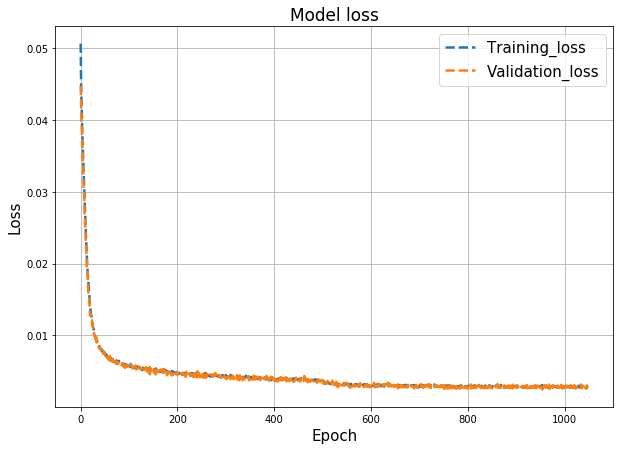

In [31]:
# No Smoothing :
legend = []
total_training_loss = training_1 + training_2 + training_3
total_valid_loss = validate_1 + validate_2 + validate_3
plt.plot(torch.Tensor(total_training_loss).detach().numpy(), linewidth = '2.5', linestyle='--')
legend.append("Training_loss")
plt.plot(torch.Tensor(total_valid_loss).detach().numpy()*4, linewidth = '2.5', linestyle='--')
legend.append("Validation_loss")
plt.title('Model loss', fontsize=17)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
## plt.legend(['Fine-Tuning Training-Loss'], fontsize=15)
plt.legend(legend, loc = 0, fontsize=15)
plt.grid(True, which="both")
plt.rcParams['figure.figsize'] = (10, 7)
plt.show()